In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [14]:
concrete = pd.read_excel("C:/Users/Usuario/OneDrive - Universidad Nacional de Colombia/Escritorio/Clases/Kaggle/Concrete/Concrete_Data.xls")
concrete.columns = ['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer', 'CoarseAggregate',
                    'FineAggregate', 'Age', 'Compressivestrength']
concrete.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,Compressivestrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Primero hacemos un modelo base entrenado en los datos originales. 

In [15]:
X = concrete.copy()
y = X.pop('Compressivestrength')

# entrenar el modelo base

baseline = RandomForestRegressor(criterion = 'absolute_error', random_state = 123)
baseline_score = cross_val_score(
    baseline, X, y, cv = 5, scoring = 'neg_mean_absolute_error'
)
baseline_score = -baseline_score.mean()

print(f'MAE baseline Score: {baseline_score:.4}')

MAE baseline Score: 8.321


Podemos combinar variables o transfromar para obtener un mejor modelo.

In [16]:
X = concrete.copy()
y = X.pop('Compressivestrength')

# Crear variables sinteticas
X['FCRatio'] = X['FineAggregate'] / X['CoarseAggregate']
X['AggCmtRatio'] = (X['CoarseAggregate'] + X['FineAggregate']) / X['Cement']
X['WtrCmtRatio'] = X['Water'] / X['Cement']

# Entrenar y evaluar el modelo con las nuevas variables

model = RandomForestRegressor(criterion = 'absolute_error', random_state = 123)
score = cross_val_score(
        model, X, y, cv = 5, scoring = 'neg_mean_absolute_error'
)

score = -score.mean()

print(f'MAE Score con nuevas variables: {score:.4}')

MAE Score con nuevas variables: 7.927


Efectivamente el error mejoró.

## Información mutua 

Ahora, como encontramos las variables útiles para combinar?

Un buen primer paso es construir una métrica de utilidad de las variables, que mida la asociación entre las variables y la variable respuesta, esta metrica se llama información mutua, la ventaja frente a la correlación es que detecta relaciones de todo tipo, no solo lineales.

La información mutua describe las relaciones en terminos de incertidumbre, la información mutua entre dos cantidades es una medida de que tanto el conocimiento de una variable reduce la incertidumbre sobre otra.

La menor información mutua entre dos variables es 0, las variables son independientes y no hay limite para la informacion mutua, en la práctica valores de más de 2 son poco comúnes. 

Esta es una metrica univariada, no puede calcular la importancia de una variable al ser unida con otras.

In [77]:
auto = pd.read_csv("C:/Users/Usuario/OneDrive - Universidad Nacional de Colombia/Escritorio/Clases/Kaggle/Automobile/Automobile_data.csv")
auto = auto[auto != '?'].dropna()
auto['price'] = auto['price'].astype('float')
auto['horsepower'] = auto['horsepower'].astype('float')

In [78]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int64  
 1   normalized-losses  159 non-null    object 
 2   make               159 non-null    object 
 3   fuel-type          159 non-null    object 
 4   aspiration         159 non-null    object 
 5   num-of-doors       159 non-null    object 
 6   body-style         159 non-null    object 
 7   drive-wheels       159 non-null    object 
 8   engine-location    159 non-null    object 
 9   wheel-base         159 non-null    float64
 10  length             159 non-null    float64
 11  width              159 non-null    float64
 12  height             159 non-null    float64
 13  curb-weight        159 non-null    int64  
 14  engine-type        159 non-null    object 
 15  num-of-cylinders   159 non-null    object 
 16  engine-size        159 non

Primero hay que separar las variables por su tipo

In [79]:
X = auto.copy()
y = X.pop('price')

# codificar variables categóricas

for colname in X.select_dtypes('object'):
    X[colname], _ = X[colname].factorize()
    
# Todas las variables discretas son tipo int

discrete_features = X.dtypes == int

Scikit learn tiene dos modluos para información mutua, (mutual_info_regression) para variables con valores reales y (mutual_info_classif) para variables categoricas

In [80]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name = 'MI scores', index = X.columns)
    mi_scores = mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
    
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

curb-weight         0.997949
engine-size         0.767695
city-mpg            0.698758
fuel-system         0.438160
num-of-cylinders    0.262076
symboling           0.191971
aspiration          0.119975
fuel-type           0.053195
num-of-doors        0.000000
Name: MI scores, dtype: float64

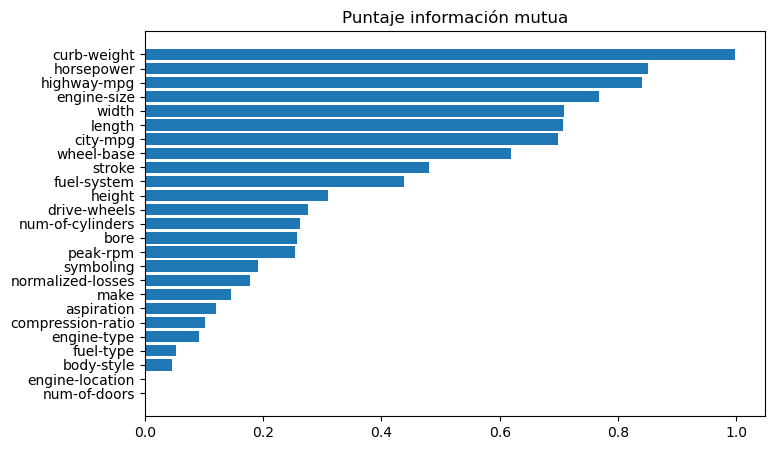

In [81]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Puntaje información mutua')
    
plt.figure(dpi = 100, figsize = (8, 5))
plot_mi_scores(mi_scores)

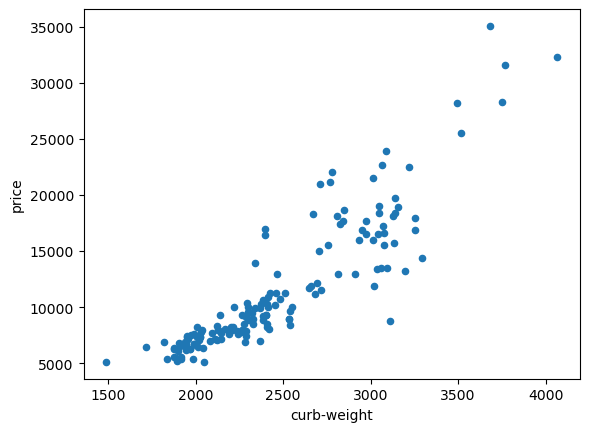

In [82]:
auto.plot(kind = 'scatter', x = 'curb-weight', y = 'price');

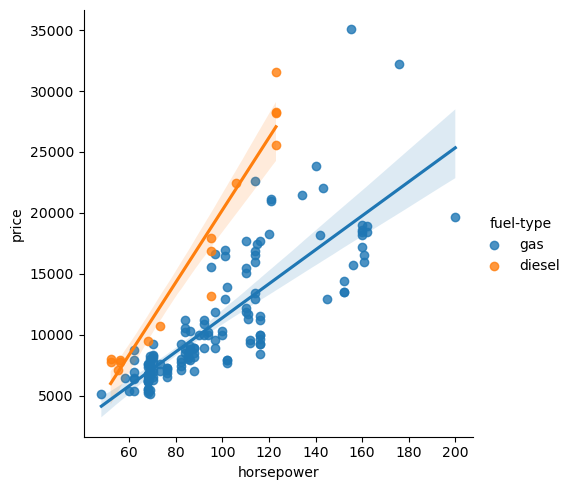

In [83]:
sns.lmplot(x = 'horsepower', y = 'price', hue = 'fuel-type', data = auto);